In [1]:
from src.utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

In [47]:
input_path = 'Data'

feature_file = 'Dragon_Descriptors.csv'
features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

mixture_file = 'Mixure_Definitions_Training_set.csv'
training_task_file = 'TrainingData_mixturedist.csv'

# Dragon features
features = pd.read_csv(os.path.join(input_path, feature_file))
features_2 = np.load(os.path.join(input_path, features_file_2))

# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
features_CIDs = np.load(os.path.join(input_path, CID_file))

In [4]:
features.head()

,CID,complexity from pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,126,5.263208,5.403263,4.683445,4.700571,4.747581,4.702233,4.759298,4.611818,4.615319,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
1,176,4.875197,5.075549,4.677565,4.649024,4.686031,4.648536,4.693630,4.610755,4.615645,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
2,177,4.703204,4.970230,4.666209,4.642158,4.673716,4.644170,4.682502,4.610536,4.615259,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
3,180,4.605170,5.063164,4.661636,4.656766,4.700280,4.660974,4.713621,4.610456,4.615101,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
4,196,5.365976,5.505982,4.675703,4.713962,4.793532,4.715145,4.811485,4.610904,4.615477,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517


In [9]:
(features > 0).all().all()

True

In [27]:
scaler = StandardScaler(with_mean=True, with_std=True)
features = scaler.fit_transform(features)

# Map CID to 96 dim features:
CID2features =  {CID: features[i] for i, CID in enumerate(features_CIDs)}

In [28]:
X, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features,'avg')

In [29]:
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)

In [30]:
X_pair1 = X_pairs[:, :96] 
X_pair2 = X_pairs[:, 96:] 

In [31]:
distances = [get_euclidean_distance(m[0], m[1]) for m in X]
similarities = [get_cosine_similarity(m[0], m[1]) for m in X]
angles = [get_cosine_angle(m[0], m[1]) for m in X]

In [32]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [33]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [34]:
### add all information above
X_features = np.hstack((X_pairs, np.array(distances).reshape(500, 1), 
                        np.array(similarities).reshape(500, 1), 
                        np.array(angles).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr))

In [35]:
dist_corr = np.corrcoef(distances, y_true)[0, 1]
print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.30170040281694677


In [36]:
sim_corr = np.corrcoef(similarities, y_true)[0, 1]
print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.3300324576306168


In [37]:
sim_corr = np.corrcoef(angles, y_true)[0, 1]
print('R (Vector angle v.s. Experimental Value): ', sim_corr)

R (Vector angle v.s. Experimental Value):  0.37596519117982685


In [38]:
training_set['Eucledian Dist'] = distances
training_set['Cosyne Sim'] = similarities
training_set['Angle'] = angles
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]


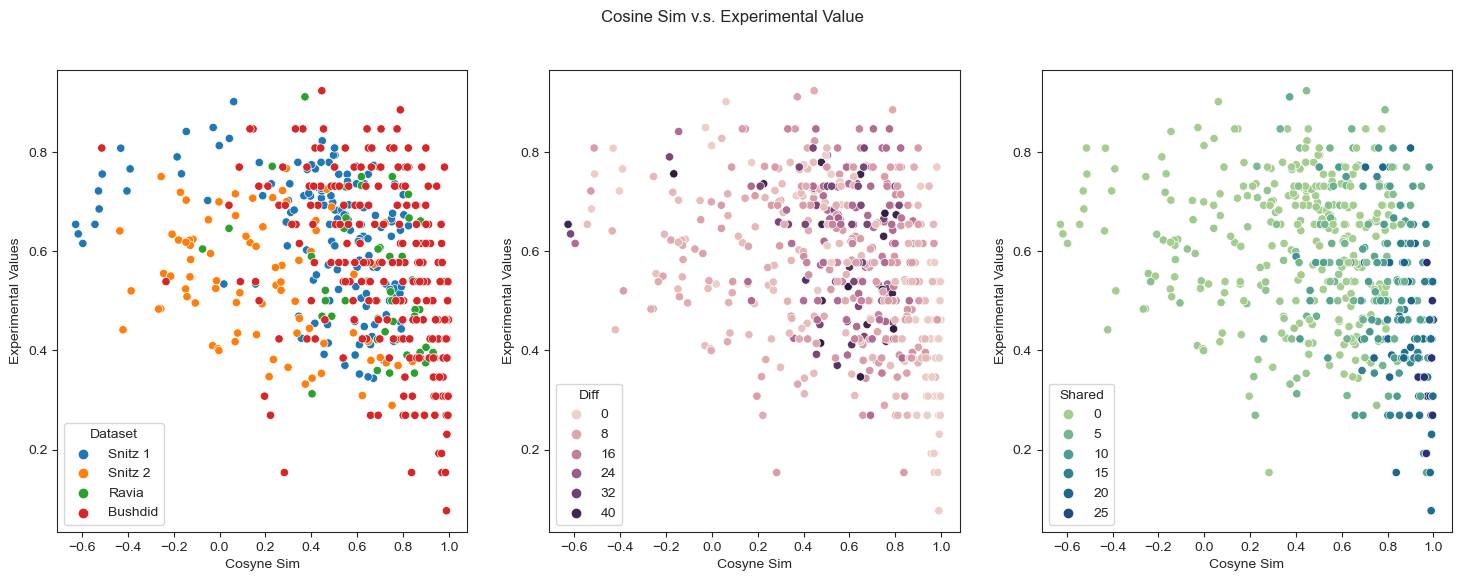

In [39]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Cosine Sim v.s. Experimental Value')
plt.show()

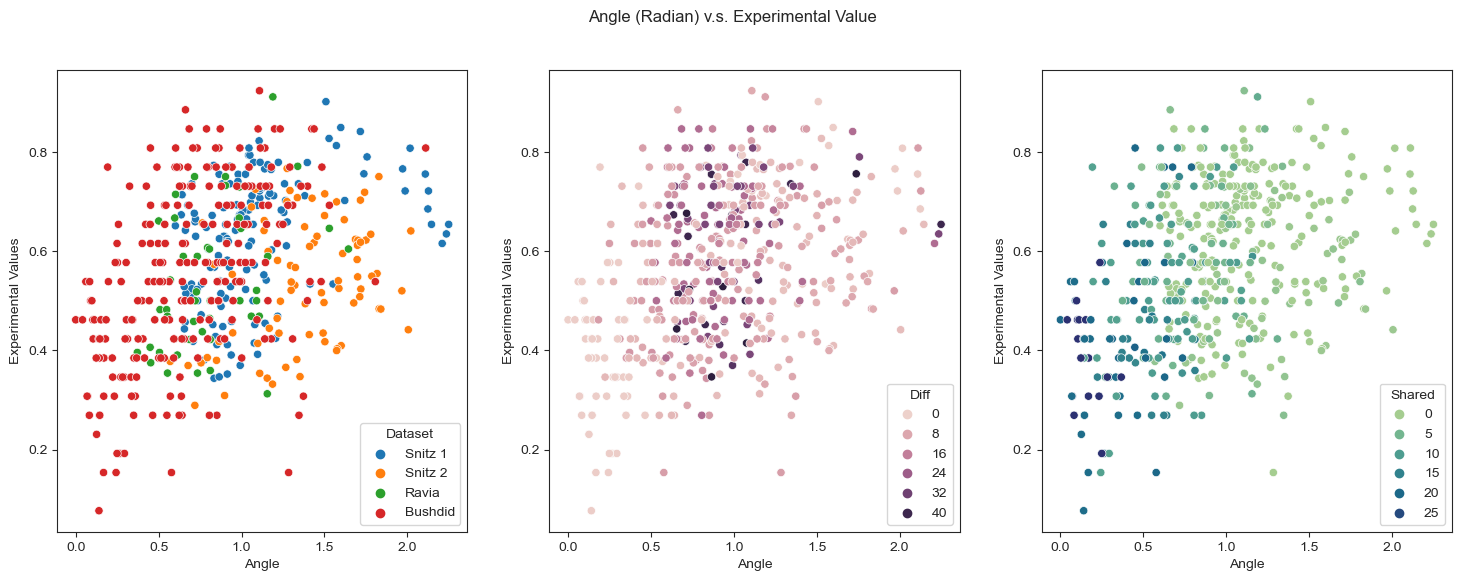

In [40]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x =  'Angle', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Angle', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Angle', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Angle (Radian) v.s. Experimental Value')

plt.show()

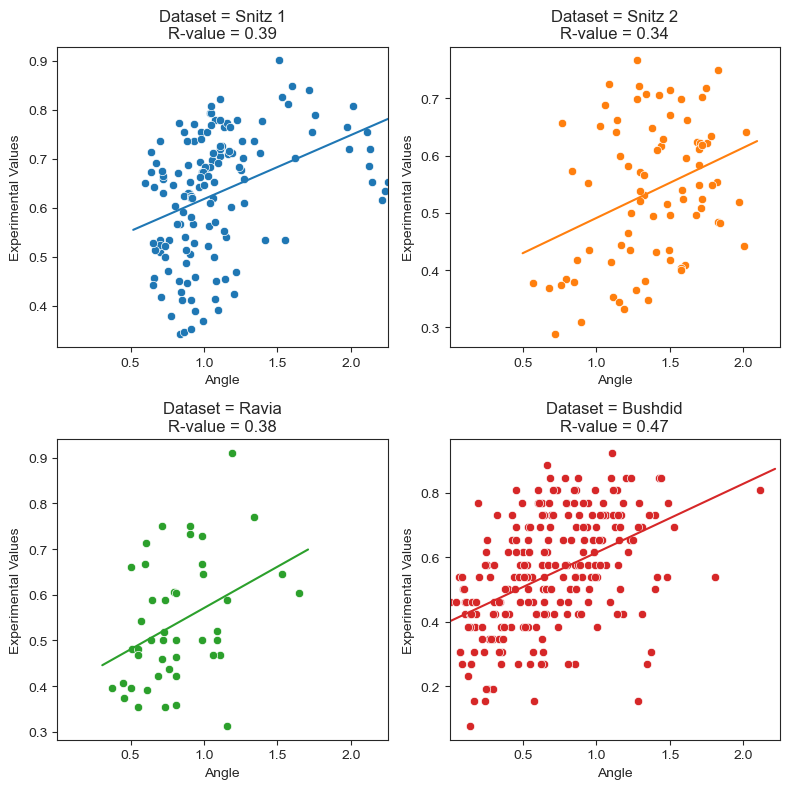

In [41]:
unique_values = training_set['Dataset'].unique()
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
color_palette = ['C0', 'C1', 'C2', 'C3']

min_angle = training_set['Angle'].min()
max_angle = training_set['Angle'].max()

for i, value in enumerate(unique_values):
    data_subset = training_set[training_set['Dataset'] == value]
    sns.scatterplot(data=data_subset, x='Angle', y='Experimental Values', ax=axs[i], color=color_palette[i])
    
    slope, intercept, r_value, _, _ = stats.linregress(data_subset['Angle'], data_subset['Experimental Values'])
    x_vals = np.array(axs[i].get_xlim()) 
    y_vals = intercept + slope * x_vals 
    axs[i].plot(x_vals, y_vals, color=color_palette[i])
    
    axs[i].set_xlim(min_angle, max_angle) 
    axs[i].set_title(f"Dataset = {value}\nR-value = {r_value:.2f}")

plt.tight_layout()
plt.show()

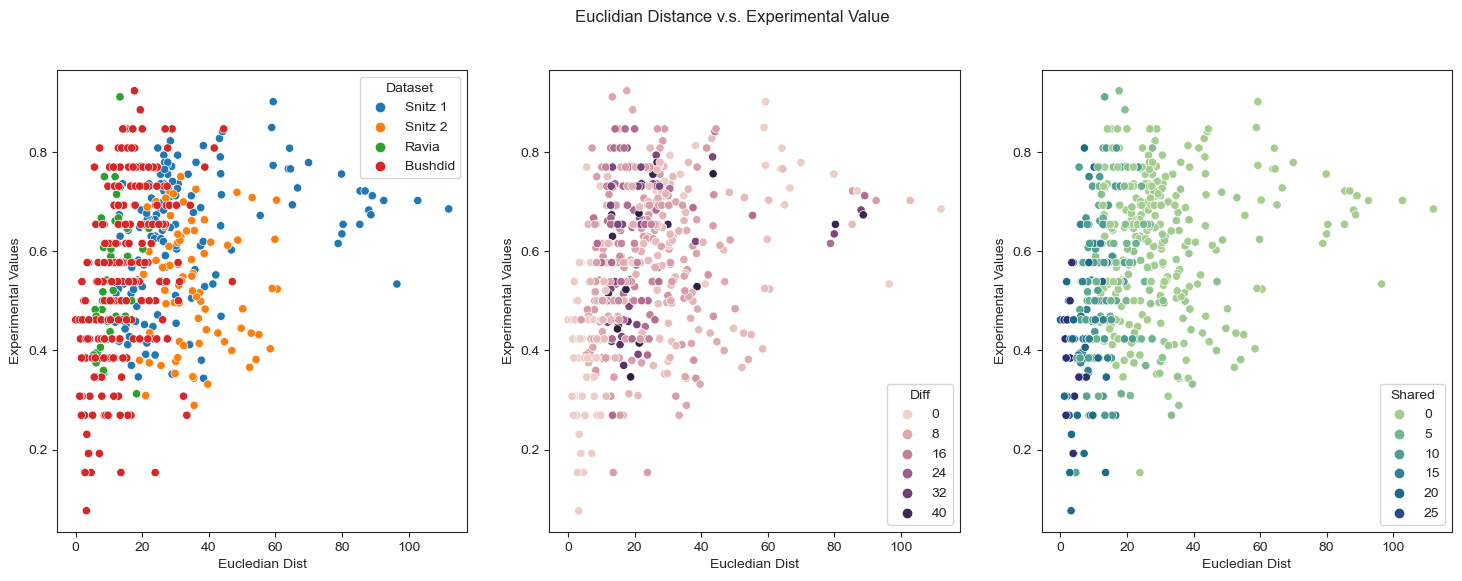

In [42]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x =  'Eucledian Dist', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Eucledian Dist', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Eucledian Dist', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Euclidian Distance v.s. Experimental Value')

plt.show()

----
## 2. Training
### 2.1 Example attempt, standard intialized RF and XGBoost

In [43]:
n_folds = 10
seed = 314159

In [44]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [45]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,Eucledian Dist,Cosyne Sim,Angle,Sum num monos,Shared,Diff,Num mixture1,Num mixture2,rf_pred,xgb_pred,y_true
150,Snitz 1,1,2,0.604167,30.305914,0.696653,0.800074,20,0,10,10,10,0.566939,0.547752,0.604167
300,Snitz 1,1,3,0.651042,43.548371,0.824857,0.600846,11,0,10,10,1,0.642157,0.627382,0.651042
0,Snitz 1,1,5,0.505208,34.814966,0.618091,0.904485,40,0,10,10,30,0.540936,0.438878,0.505208
1,Snitz 1,1,6,0.411458,34.208288,0.658830,0.851533,50,0,10,10,40,0.557311,0.462707,0.411458
50,Snitz 1,1,7,0.562500,35.808701,0.513909,1.031061,14,0,10,10,4,0.564297,0.648853,0.562500


In [46]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.595
Random Forest - RMSE: 0.126

XGBoost - R: 0.544
XGBoost - RMSE: 0.133
